Fix the seeds

In [ ]:
import random
import torch
import numpy

def set_random_seed(seed):
    torch.manual_seed(seed)
    numpy.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

# Dataset

In [ ]:
!pip -q install torch
!pip -q install torchvision

In [ ]:
import torch
from scipy.linalg import hadamard

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Cuda available: ", torch.cuda.is_available(), '\n')

# Creating Hadamard matrix, where each row is 32x32 hadamard pattern with {-1,1} elements
px = 32
H = torch.from_numpy(hadamard(px**2)).to(device)
# In real (physical) single pixel mesurements we use matrixes
Hplus = (H + 1) / 2
Hminus = (1 - H) / 2

Cuda available:  True 



Here are the functions, which create mesurements vectror for all patterns in Hadamard basis

In [ ]:
def measurement(img):
    Mplus = torch.matmul(Hplus, img.flatten().float()).to(device)
    Mminus = torch.matmul(Hminus, img.flatten().float()).to(device)
    M = (Mplus - Mminus)

    return M

In [ ]:
def batch_measurements(imgs):
    vect = torch.zeros(len(imgs), len(imgs[0]) ** 2)

    for i in range(len(imgs)):
        img = imgs[i].to(device)
        vect[i] = measurement(img)

    return vect

Dataset with single-pixel mesuarements and their class labels

In [ ]:
from torchvision import transforms
from torch.utils.data.dataset import Dataset

class MesurementDataset(Dataset):
    def __init__(self, mnist):
        super().__init__()
        self.labels = mnist.targets
        images = mnist.data
        transform = transforms.Compose([transforms.ConvertImageDtype(torch.float32),
                                        transforms.Resize(32)])

        self.target_images = transform(images)

        self.measurements = batch_measurements(self.target_images).cpu()

    def __getitem__(self, indx):
        return self.measurements[indx], self.labels[indx]

    def __len__(self):
        return len(self.measurements)

In [ ]:
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from IPython.display import clear_output

train_set = MesurementDataset(MNIST(root='./MNIST', train=True, download=True))
test_set = MesurementDataset(MNIST(root='./MNIST', train=False, download=True))

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

clear_output()

To create an underdefined system of equlations we need to select the most important ones, so we need to calculate variance

In [ ]:
import numpy as np

variance = np.array([])
for i in range(1024):
    measurements_for_pattern = train_set[:][0][:,i]
    variance = np.append(variance, np.var(measurements_for_pattern.numpy()))

The most important patterns - with biggest dispersion trough the dataset

In [ ]:
most_important = np.argsort(variance)[-64:]

# Model

In [2]:
!pip -q install pennylane

Model characteristics

In [7]:
num_classes = 10
feature_size = 64
# number of qubits - logarithm of numbers of features
num_qubits = int(np.ceil(np.log2(feature_size)))

num_layers = 6
margin = 0.15

lr_adam = 0.01
num_epochs = 3
batch_size = 10

dev = qml.device("default.qubit", wires=num_qubits)

Creating variational quantum circuit

In [3]:
import pennylane as qml

# strongly entangled layer
def layer(W):
    for i in range(num_qubits):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
    for j in range(num_qubits - 1):
        qml.CNOT(wires=[j, j + 1])
    if num_qubits >= 2:
        qml.CNOT(wires=[num_qubits - 1, 0])

In [8]:
def circuit(weights, feat=None):
    qml.AmplitudeEmbedding(feat, range(num_qubits), pad_with=0.0, normalize=True)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0)) # observable

# for ten different classifiers
qnodes = []
for iq in range(num_classes):
    qnode = qml.QNode(circuit, dev, interface="torch")
    qnodes.append(qnode)

In [ ]:
def variational_classifier(q_circuit, params, feat):
    weights = params[0]
    bias = params[1]
    return q_circuit(weights, feat=feat) + bias

How one classifier looks like (state preparation, one layer measurements)

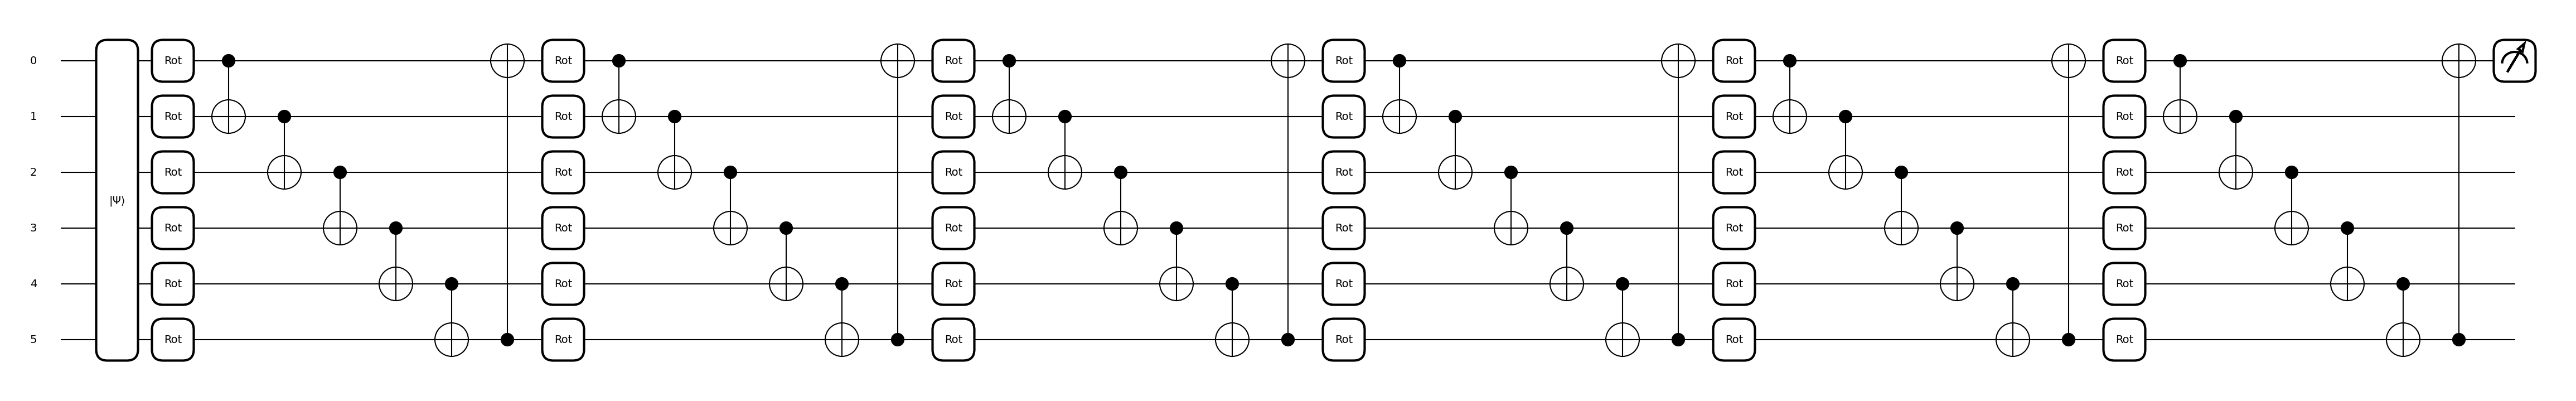

In [16]:
from matplotlib import pyplot as plt
from torch.autograd import Variable

all_weights = Variable(0.1 * torch.randn(6, 10, 3), requires_grad=True)
all_bias = Variable(0.1 * torch.ones(1), requires_grad=True)
params = (all_weights, all_bias)

fig, ax = qml.draw_mpl(circuit)(params[0], params[1])
plt.show()

Margin loss for the results of ten classifiers

In [ ]:
import time
def margin_loss(q_circuits, all_params, feature_vecs, true_labels):
    loss = 0
    num_samples = len(true_labels)
    for i, feature_vec in enumerate(feature_vecs):
        feature_vec = feature_vec.to(device)

        # Let's calculate the score assigned to this sample by the classifier corresponding to the true label
        s_true = variational_classifier(q_circuits[int(true_labels[i])],
                                        (all_params[0][int(true_labels[i])], all_params[1][int(true_labels[i])]),
                                        feature_vec)
        s_true = s_true.float()

        # Let's get values for the wrong classes
        li = 0
        for j in range(num_classes):
            if j != int(true_labels[i]):
                s_j = variational_classifier(q_circuits[j],
                                            (all_params[0][j], all_params[1][j]),
                                             feature_vec)
                s_j = s_j.float()
                li += torch.max(torch.zeros(1).to(device).float(), s_j - s_true + margin)
        loss += li

    return loss / num_samples

To get prediction and it's accuracy

In [ ]:
def classify(q_circuits, all_params, feature_vecs, labels):
    predicted_labels = []
    for i, feature_vec in enumerate(feature_vecs):
        scores = np.zeros(num_classes)
        for c in range(num_classes):
            score = variational_classifier(q_circuits[c],
                                           (all_params[0][c], all_params[1][c]),
                                           feature_vec)
            scores[c] = float(score)
        pred_class = np.argmax(scores)
        predicted_labels.append(pred_class)
    return predicted_labels


def accuracy(labels, hard_predictions):
    acc = 0
    for l, p in zip(labels, hard_predictions):
        if torch.abs(l - p) < 1e-5:
            acc += 1
    acc = acc / labels.shape[0]
    return acc

Class for plots

In [ ]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output


class ProgressPlotter:
    def __init__(self) -> None:
        self._history_dict = defaultdict(list)

    def add_scalar(self, tag: str, value) -> None:
        self._history_dict[tag].append(value)

    def display_plot(self) -> None:
        clear_output()
        n_keys = len(self._history_dict)
        fig, ax = plt.subplots(n_keys, 1, figsize=(12, 3 * n_keys))
        for key_idx, key in enumerate(self._history_dict.keys()):
            history_len = len(self._history_dict[key])
            if n_keys == 1:
                ax.plot(self._history_dict[key], color="c", marker="X")
                ax.set_ylabel(key)
                ax.set_xlabel("step")
                ax.set_xticks(np.arange(history_len))
                ax.set_xticklabels(np.arange(history_len))
            elif n_keys > 1:
                ax[key_idx].plot(self._history_dict[key], color="c", marker="X")
                ax[key_idx].set_ylabel(key)
                ax[key_idx].set_xlabel("step")
                ax[key_idx].set_xticks(np.arange(history_len))
                ax[key_idx].set_xticklabels(np.arange(history_len))
        fig.tight_layout()
        plt.show()

Training

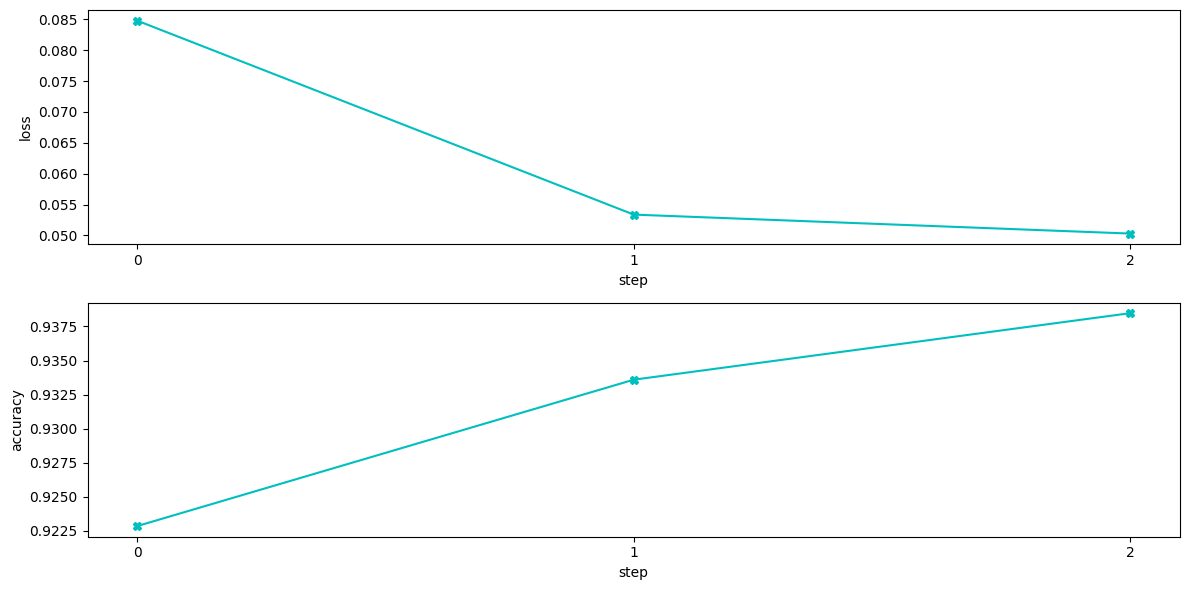

CPU times: user 2d 1h 5min 53s, sys: 29.3 s, total: 2d 1h 6min 22s
Wall time: 2d 1h 6min 7s


In [ ]:
%%time

from torch.autograd import Variable
import torch.optim as optim

device = torch.device("cpu")

pp = ProgressPlotter()
q_circuits = qnodes

device = ""

# Random parameters initialization
all_weights = [Variable(0.1 * torch.randn(num_layers, num_qubits, 3).to(device), requires_grad=True) for i in range(num_classes)]
all_bias = [Variable(0.1 * torch.ones(1).to(device), requires_grad=True) for i in range(num_classes)]

optimizer = optim.Adam(all_weights + all_bias, lr=lr_adam)

params = (all_weights, all_bias)
print("Num params: ", num_classes * (3 * num_layers * num_qubits * 3 + 1))

for e in range(num_epochs):
    loss = 0
    for i, batch in enumerate(train_loader):
        measurements, labels = batch
        measurements, labels = measurements.to(device), labels.to(device)

        x = measurements[:, most_important].to(device)

        optimizer.zero_grad()

        curr_cost = margin_loss(q_circuits, params, x, labels)
        loss += curr_cost.detach().cpu().numpy()[0]
        curr_cost.backward()

        optimizer.step()

        print(f"Train: Epoch {e}, batch #{i+1}/{len(train_loader)}, loss={curr_cost.detach().cpu().numpy()[0]}")

    loss /= len(train_loader)

    acc = 0
    for i, batch in enumerate(test_loader):
        measurements, labels = batch
        measurements, labels = measurements.to(device), labels.to(device)

        x = measurements[:, most_important].to(device)

        pred = classify(q_circuits, params, x, labels)
        acc += accuracy(labels, pred)

        print(f"Validation: Epoch {e}, batch #{i+1}/{len(test_loader)}, accuracy={accuracy(labels, pred)}")

    acc /= len(test_loader)

    pp.add_scalar(tag="loss", value=loss)
    pp.add_scalar(tag="accuracy", value=acc)
    pp.display_plot()